In [1]:
import numpy as np
import os
import torch

import torchvision.models as models

import copy

random_seed = 4545435
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#  Создает в директории csv файл, размечающий картинки
def generate_csv_classes(file_name):
    file_csv = open(file_name, "w+")
    count_class = 0
    res = "filename, full_filename, num_class\n"
    for i in os.listdir("../resized_images"):
        for j in os.listdir("../resized_images"+os.sep+i):

            res += "{},{},{}\n".format(j.split(".")[0], "../resized_images"+os.sep+i+os.sep+j, count_class)
        count_class+=1
           
    file_csv.write(res)
    file_csv.close()
generate_csv_classes("sample_full.csv")

In [3]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class MyCustomDataset(Dataset):
    def __init__(self, dict_name):
        self.transformations = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        self.class_dict = pd.read_csv(dict_name)
        self.data_len = len(self.class_dict.index)
        
    def __getitem__(self, index):
        res_row = self.class_dict.iloc[index]
        full_filename = res_row[1]
        data = Image.open(full_filename).convert('RGB').resize((224, 224))
        data = self.transformations(data)  # (3)
        label = res_row[2]
        return (data, label)

    def __len__(self):
        
        return self.data_len

In [4]:
data = MyCustomDataset("sample_full.csv")

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler 
dataset_size = len(data) 
indices = list(range(dataset_size)) 
validation_split = 0.4
split = int(np.floor(validation_split * dataset_size))

np.random.seed(random_seed) 
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices) 
valid_sampler = SubsetRandomSampler(val_indices)
BATCH_SIZE = 1
train_loader = DataLoader(data, batch_size = BATCH_SIZE,  num_workers=0, sampler=train_sampler)

val_loader = DataLoader(data, batch_size = BATCH_SIZE, num_workers=0, sampler=valid_sampler)
print(len(train_loader))

250


In [6]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [7]:
def gram_matrix(inp):
    a, b, c, d = inp.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = inp.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [8]:
import torch.nn as nn
import torch.nn.functional as F


cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    

In [9]:
class StyleMatrix(nn.Module):

    def __init__(self):
        super(StyleMatrix, self).__init__()

    def forward(self, inp):
        G = gram_matrix(inp)
        return G

In [10]:
model = copy.deepcopy(cnn)
model = torch.nn.Sequential(*(list(model.children())[:26])+[StyleMatrix()])
print(model)  # Сама сетка (можно посчитать, что последний conv - тот, который нужен)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

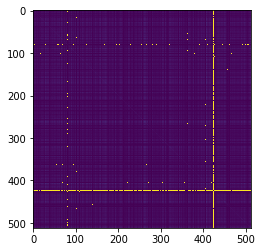

tensor([[0.0441, 0.0474, 0.0362,  ..., 0.0330, 0.0557, 0.0414],
        [0.0474, 0.0703, 0.0441,  ..., 0.0376, 0.0710, 0.0473],
        [0.0362, 0.0441, 0.0472,  ..., 0.0362, 0.0512, 0.0413],
        ...,
        [0.0330, 0.0376, 0.0362,  ..., 0.0479, 0.0498, 0.0388],
        [0.0557, 0.0710, 0.0512,  ..., 0.0498, 0.0932, 0.0600],
        [0.0414, 0.0473, 0.0413,  ..., 0.0388, 0.0600, 0.0488]],
       grad_fn=<DivBackward0>)


In [28]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2

for (images, labels) in data:
    G_matrix = model(torch.reshape(images, (1, 3, 224, 224)))
    trans = transforms.ToPILImage()
    plt.imshow(trans(G_matrix))
    plt.show()
    print(G_matrix)
    break
#     trans = transforms.ToPILImage()
#     plt.imshow(trans(G_matrix))
#     plt.show()
